In [1]:
import numpy as np
import overreact as rx
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import os
from overreact import datasets
from overreact import constants

In [3]:
sns.set(style="white", context="notebook", palette="colorblind", font_scale=1.1)

In [4]:
# Thanks Pérez-Soto et al. for the data!
# You can find it in the SI of the paper: https://doi.org/10.1021/acs.orglett.0c00367
t_exp = [0.0, 177.2, 463.4, 749.7, 1049.5, 1335.7, 1908.2, 2494.3, 3066.8, 4225.3]  # [s]
imine_exp = [0.000, 3.391, 11.600, 17.846, 23.021, 26.769, 33.015, 37.477, 41.046, 46.043]  # [mM]

In [5]:
# Their bias, used in our paper as well
bias = 3.2

# Our bias, obtained by minimizing the root-mean-square deviation against the experimental data
# bias = 3.15

In [6]:
# How do I get help on a function?
# ?rx.get_k

In [7]:
model = rx.parse_model(
    os.path.join(datasets.data_path, "perez-soto2020/RI/B3LYP-D3BJ/cc-pVTZ/model.k")
)
k_eck = rx.get_k(
    model.scheme, model.compounds, temperature=298.15, scale="M-1 s-1", bias=bias * constants.kcal,
)

assuming ground state as electronic energy at zero temperature
assuming rotational energy zero at zero temperature
assuming zero point as vibrational energy at zero temperature
assuming rotational energy zero at zero temperature
assuming ground state as electronic energy at zero temperature
assuming rotational energy zero at zero temperature
assuming zero point as vibrational energy at zero temperature
assuming rotational energy zero at zero temperature
assuming ground state as electronic energy at zero temperature
assuming rotational energy zero at zero temperature
assuming zero point as vibrational energy at zero temperature
assuming rotational energy zero at zero temperature
assuming ground state as electronic energy at zero temperature
assuming rotational energy zero at zero temperature
assuming zero point as vibrational energy at zero temperature
assuming rotational energy zero at zero temperature
assuming ground state as electronic energy at zero temperature
assuming rotational e

In [8]:
model.scheme.compounds

('Benzaldehyde(dcm)',
 'NButylamine(dcm)',
 'A_N(dcm)',
 'A_N_N(dcm)',
 'Water(dcm)',
 'A_N_W(dcm)',
 'A_N_N_W(dcm)',
 'A_N_W_W(dcm)',
 'TS1_#(dcm)',
 'Hemiaminal(dcm)',
 'TS2_#(dcm)',
 'I_W(dcm)',
 'TS1N_#(dcm)',
 'Int_N(dcm)',
 'TS2N_#(dcm)',
 'I_N_W(dcm)',
 'TS1W_#(dcm)',
 'Int_W(dcm)',
 'TS2W_#(dcm)',
 'I_W_W(dcm)',
 'TS1NW_#(dcm)',
 'Int_N_W(dcm)',
 'TS2NW_#(dcm)',
 'I_N_W_W(dcm)',
 'TS1WW_#(dcm)',
 'Int_W_W(dcm)',
 'TS2WW_#(dcm)',
 'I_W_W_W(dcm)',
 'Imine(dcm)')

In [9]:
# y0_Cl = 0.1e-6
# y0_CH4 = 2.5 * y0_Cl
# y0_HCl = 0.25 * y0_Cl

# y0 = [y0_CH4, y0_Cl, 0.0, 0.0, y0_HCl]
# y0

y0 = np.zeros_like(model.scheme.compounds, dtype=float)
y0[model.scheme.compounds.index("Benzaldehyde(dcm)")] = 0.06
y0[model.scheme.compounds.index("NButylamine(dcm)")] = 0.06
y0[model.scheme.compounds.index("Water(dcm)")] = 0.001

y0

array([0.06 , 0.06 , 0.   , 0.   , 0.001, 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   ,
       0.   , 0.   ])

In [10]:
# Help again
# ?rx.get_y

In [11]:
dydt = rx.get_dydt(model.scheme, k_eck)
y, r = rx.get_y(dydt, y0=y0, max_time=5000)

In [12]:
y.t_max

5000.0

In [13]:
def is_imine(name):
    "Check if name is an imine"
    return "I_" in name or "Imine" in name

def do_we_want(name):
    "Filter out the species we want in the plot"
    markers = [
        # Reactants
        "NButylamine", "Benzaldehyde", "Water",
        # Products
        # "Imine", "I_"
    ]

    return not rx.is_transition_state(name) and \
        (
            any([marker in name for marker in markers]) or \
            is_imine(name)
        )

def pretty_name(name):
    "Make a name pretty for the graph"
    return name \
        .replace("(dcm)", "") \
        .replace("Water", "Water (W)") \
        .replace("NButylamine", "N-Butylamine (N)") \
        .replace("I_", "Imine@") \
        .replace("W_W_W", "3W") \
        .replace("W_W", "2W") \
        .replace("_", "+")

Including  Benzaldehyde
Including  N-Butylamine (N)
Including  Water (W)
Including  Imine@W
Including  Imine@N+W
Including  Imine@2W
Including  Imine@N+2W
Including  Imine@3W
Including  Imine


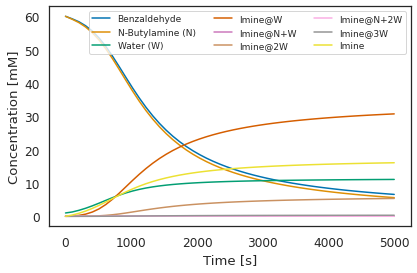

In [14]:
t = np.linspace(y.t_min, y.t_max)

fig, ax = plt.subplots()
for i, name in enumerate(model.scheme.compounds):
    if do_we_want(name):
        print("Including ", pretty_name(name))
        ax.plot(t, 1e3 * y(t)[i], label=pretty_name(name))

ax.set_ylabel("Concentration [mM]")
ax.set_xlabel("Time [s]")

ax.legend(loc="upper right", ncol=3, prop={"size": 9})  #, bbox_to_anchor=(1, 1))
fig.tight_layout()

In [15]:
def total_imine(t):
    "Sum all imines for time `t` (in the most inefficient way possible); return total concentration in molar"
    t = np.asanyarray(t, dtype=float)
    acc = np.zeros_like(t)
    for i, name in enumerate(model.scheme.compounds):
        if is_imine(name):
            # print("Including ", pretty_name(name))  # for debugging
            acc += y(t)[i]  # we multiply by 1e3 when plotting
    return acc

In [16]:
bias

3.2

In [17]:
# Poor man's minimization (raw data)
# bias (kcal/mol) | root mean square deviation (RMSD)
#             0.00 | 28.2475345980222  # for comparison
#             0.50 | 27.961255987747588
#             1.00 | 24.76049671498034
#             1.50 | 11.72477180552866
#             2.00 | 6.606131725982375
#             2.40 | 6.035832466141071
#             2.80 | 5.819081686541392
#             3.00 | 5.115578334375486
#             3.05 | 4.9122998913649125
#             3.10 | 4.7705801658226115
#             3.15 | 4.763225960416199
#             3.20 | 4.974551104098317
#             3.30 | 6.382070549724067
#             3.40 | 8.92425542253737
#             3.70 | 18.198245046694062
#             4.00 | 24.52328539148892
np.sqrt(np.mean((1e3 * total_imine(t_exp) - imine_exp) ** 2))

4.974551104098317

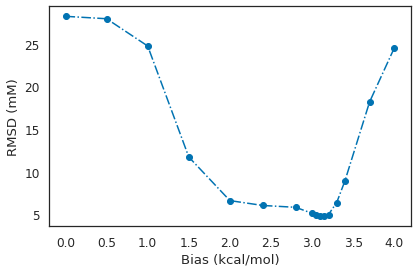

In [18]:
biases = [0.0, 0.5, 1.0, 1.5, 2.0, 2.4, 2.8, 3.0, 3.05, 3.1, 3.15, 3.2, 3.3, 3.4, 3.7, 4.0]
rmsds = [28.2475345980222,   27.961255987747588, 24.76049671498034,  11.72477180552866,
          6.606131725982375,  6.035832466141071,  5.819081686541392,  5.115578334375486,
          4.9122998913649125, 4.7705801658226115, 4.763225960416199,  4.974551104098317,
          6.382070549724067,  8.92425542253737,  18.198245046694062, 24.52328539148892]
fig, ax = plt.subplots()
ax.plot(biases, rmsds, ls="-.")
ax.scatter(biases, rmsds)
# ax.set_xlim(2.9, 3.4)
# ax.set_ylim(4, 7)
ax.set_xlabel("Bias (kcal/mol)")
ax.set_ylabel("RMSD (mM)")
fig.tight_layout()

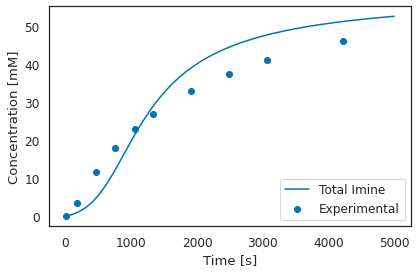

In [19]:
fig, ax = plt.subplots()
ax.plot(t, 1e3 * total_imine(t), label="Total Imine")
ax.scatter(t_exp, imine_exp, label="Experimental")

ax.set_ylabel("Concentration [mM]")
ax.set_xlabel("Time [s]")

ax.legend(loc="lower right")
fig.tight_layout()